In [ ]:
#############################################################
# Compile `main.cu` to `file.exe`
# Commented out because we don't want to run it all the time
#############################################################
!nvcc -w functions.cu main.cu -o file

In [1]:
#############################################################
# Load python dependencies
# If package cannot be resolved from pylance, reload the interpreter
#############################################################
import numpy as np
import matplotlib.pyplot as plt
import utils
import os.path

# Generate detuning
todo: distribution functions
read into detuning.dat

In [ ]:
#############################################################
# Generate and write detuning data to file
#############################################################
# Write 1D numpy array to file
detuning_values_1d = utils.gen_same_pop(2, 1000, None)
print("Detuning data:", detuning_values_1d)
np.savetxt("Detuning.dat", detuning_values_1d, delimiter="\t")

# Example: write 2D numpy array to file
# values_2d = np.array([
#     [10.0, 20.0, 40.0],
#     [10.0, 20.0, 50.0],
#     [10.0, 20.0, 60.0]
# ])
# np.savetxt("values_2d.dat", values_2d, delimiter="\t")

# Run simulation

To run a single system, use terminal: 

         k  n_tot theta,phi g gamma chi kap t_end t_num handle

file.exe 20 100000 0.5 0.0 1.6 0.0 0.0 160 0.5 600000 k20N5_0.5_0_kappa160

## Suggested file naming convention:
k{num_ens}N{order of magnitude of n_total}_{theta_phi}_{other params}

E.g., k5N5_1_0_kappa160

The below block of code is useful for running multiple jobs

num_ens:			3
N_total:			500000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.31 s
(-1, 0.14430649999999998)


0.01427

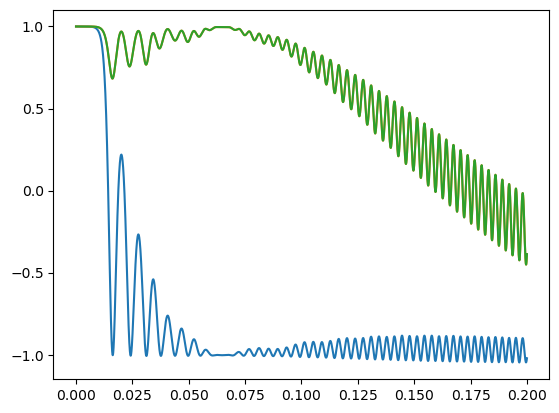

In [3]:
#############################################################
# Test 3: for initial cases, "single use", tested utils.crit1
#############################################################
N_tot = 500000
num_ens = 3
theta_0 = 1
phi_0 = 0.0
coup_a_0 = 1.0
gamma_a_0 = 0.0
chi_a_0 = 0.0
kappa_c_0 = 100.0
t_max = 0.2
t_num = 60000
run = 0
det_dict = {}
handle_list = []
delta_min = 0
delta_crit = delta_min
delta_max = 1000
detuning_max = [0, -delta_max, delta_max]

# Run
np.savetxt("Detuning.dat", detuning_max, delimiter="\t")
params = f'{num_ens} {N_tot} {theta_0} {phi_0} {coup_a_0} {gamma_a_0} {chi_a_0} {kappa_c_0} {t_max} {t_num}'
handle_max = f'k{num_ens}N{N_tot}det{delta_max}_{theta_0}_{coup_a_0}_{kappa_c_0}_test3_0'
handle_list.append(handle_max)
det_dict[handle_max] = detuning_max
utils.runcmd(f'file.exe {params} {handle_max}')
result = utils.read_results(handle_max)
print(utils.crit_1(handle_max))
plt.plot(result[0], result[1])
utils.findTd(result[1][:,0], result[0])


In [ ]:
print(os.path.isfile(f"Result_Sz_{handle_max}.dat"))

In [3]:
#############################################################
# Test 3: Find critical detuning
# Criterion 1: Td <1.05 Td(0)
# Criterion 2: sz_delta < -0.8
# System {-d, 0, d}
#############################################################
N_tot_range = [500000] # Start with the largest ensemble
num_ens = 3
theta_0 = 1
phi_0 = 0.0
coup_a_0 = 1.0
gamma_a_0 = 0.0
chi_a_0 = 0.0
kappa_c_0 = 100.0
t_max = 0.2
t_num = 60000
det_dict = {}
handle_list = []
delta_min = 300
delta_max = 500
delta_crit = delta_max # Temporary variable
tol = 5e-4 # Tolerance
delta_crit_1 = [] # Storing critical detunings satisfying crit1
delta_crit_2 = []

for N_tot in N_tot_range:
    # Run initial test to see if the current range is ok
    crit1 = 0
    crit2 = 0 # Criterion 2 default false
    found1 = False
    found2 = False
    run = 0
    max_run = 10
    delta_max = delta_crit # Smaller ensembles have smaller critical detuning
    
    # Initial check: crit1 fails at delta_max
    while(crit1 !=-1):
        detuning_max = [0, -delta_max, delta_max]
        np.savetxt("Detuning.dat", detuning_max, delimiter="\t")
        params = f'{num_ens} {N_tot} {theta_0} {phi_0} {coup_a_0} {gamma_a_0} {chi_a_0} {kappa_c_0} {t_max} {t_num}'
        handle_max = f'k{num_ens}N{N_tot}det{delta_max}_{theta_0}_{coup_a_0}_{kappa_c_0}_test3_{run}'
        print(handle_max)
        # Check if file already exists
        if os.path.isfile(f"Result_Sz_{handle_max}.dat") == False:
            utils.runcmd(f'file.exe {params} {handle_max}')
        else:
            print("File exits, skipping simulation")
        #utils.runcmd(f'file.exe {params} {handle_max}')
        [crit1,diff] = utils.crit_1(handle_max)
        if crit1 == 0: # delta_max is the critical detuning for crit1
            delta_crit_1.append(delta_max)
            found1 = True
            print(f"delta_crit1 has been found at boundary {delta_max}")
        elif crit1 == 1: # delta_max is smaller than critical detuning for crit1
            delta_max += 100
            print(f"delta_max smaller than critical, increase by 100 to {delta_max}")
        # break (auto) delta_max is larger than critical detuning for crit 1
    
    # Start searching by binary
    while(run<max_run and delta_max-delta_min>10):
        run += 1
        delta_mid = (delta_max + delta_min)/2
        detuning_mid = [0, -delta_mid, delta_mid]
        np.savetxt("Detuning.dat", detuning_mid, delimiter="\t")   
        handle_mid = f'k{num_ens}N{N_tot}det{delta_mid}_{theta_0}_{coup_a_0}_{kappa_c_0}_test3_{run}' # Add extra notes as needed
        handle_list.append(handle_mid)
        det_dict[handle_mid] = detuning_mid
        print(f"************************* {N_tot} Run {run} Detuning {delta_mid} *************************")
        print(f"Handle: {handle_mid}")
        if os.path.isfile(f"Result_Sz_{handle_mid}.dat") == False:
            utils.runcmd(f'file.exe {params} {handle_mid}')
        else:
            print("File exits, skipping simulation")
        [crit1,diff] = utils.crit_1(handle_mid)
        if crit1 == 0 or diff<tol:
            delta_crit_1.append(delta_mid)
            found1 = True
            print(f"delta_crit1 has been found at run {run}: {delta_mid}")
            break
        elif crit1 == -1:
            delta_max = delta_mid
            print(f"Detuning {delta_mid} too large, diff {diff}, next round")
        elif crit1 == 1:
            delta_min = delta_mid
            print(f"Detuning {delta_mid} too small, diff {diff}, next round")
    
    # if found1 == False:
    #     delta_mid = (delta_min + delta_max)/2
    #     handle_mid = f'k{num_ens}N{N_tot}det{delta_mid}_{theta_0}_{coup_a_0}_{kappa_c_0}_test3_{run+1}' # Add extra notes as needed
    #     handle_list.append(handle_mid)
    #     det_dict[handle_mid] = detuning_mid
    #     print(f"************************* {N_tot} Run {run} *************************")
    #     print(f"Handle: {handle_mid}")
    #     if os.path.isfile(f"Result_Sz_{handle_mid}.dat") == False:
    #         utils.runcmd(f'file.exe {params} {handle_mid}')
    #     else:
    #         print("File exits, skipping simulation")
    #     [crit1,diff] = utils.crit_1(handle_mid)
    #     delta_crit_1.append(delta_mid)
    #     print(f"Exceeded max-iter or smallest step, critical detuning taken as {delta_mid}, diff {diff}")
    #     found1 == True
    #     break

k3N500000det500_1_1.0_100.0_test3_0
File exits, skipping simulation
************************* 500000 Run 1 Detuning 400.0 *************************
Handle: k3N500000det400.0_1_1.0_100.0_test3_1
num_ens:			3
N_total:			500000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




KeyboardInterrupt: 

# Analyze & Plot
todo:  import util functions return predict Td
write block to plot with Td and found Td

In [ ]:
#############################################################
# Read in the results file
# Returns: 
#         [0]: time steps
#         [1]: sz
#         [2]: coherence
#         [3]: photons
#############################################################
results = []
detunings = []
for i in range(np.size(handle_list)):
    results.append(utils.read_results(handle_list[i])) # Input: file handle
    detunings.append(det_dict[handle_list[i]])
# results = utils.read_results(handle_list[0]) # Input: file handle
print(detunings)

In [ ]:
#############################################################
# Plots intracavity field
#############################################################
for i in [0,6,7]:
    end_ind = utils.cut_time(results[0][0], -1)
    print(end_ind)
    plt.plot(results[i][0], results[i][3], label=[int(k) for k in detunings[i]])
plt.title("Intracavity photon", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle a^\dagger a\rangle$", fontsize=12)
plt.legend()

In [ ]:
# More code on diff photons
ada_03 = (results[3][3]-results[1][3])/results[1][3]*100
ada_13 = (results[5][3]-results[4][3])/results[4][3]*100
ada_23 = (results[7][3]-results[6][3])/results[6][3]*100
plt.plot(results[0][0], ada_13, label=r"[0,$\delta/3$, $\delta$]-[0,$\delta/2$]")
plt.plot(results[0][0], ada_03, label=r"[0,$\delta/2$, $\delta$]-[0,$\delta/3$]")
plt.plot(results[0][0], ada_23, label=r"[0,$2\delta/3$, $\delta$]-[0,$2\delta/3$]")
plt.title("Intracavity photon difference", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\Delta\langle a^\dagger a\rangle (\%)$", fontsize=12)
plt.legend()

In [ ]:
#############################################################
# Line plots for inversion and coherence
#############################################################
for i in [0,4,5]:
    if len(detunings[i])<2:
        plt.plot(results[i][0], results[i][1], label=int(detunings[i]))
    else:
        plt.plot(results[i][0], results[i][1][:,0], label=[int(k) for k in detunings[i]])

# Td = utils.findTd(results[0][1], results[0][0])
# print(Td)
plt.title("Atomic inversion (1st class)", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_Z \rangle$", fontsize=12)
plt.legend()

In [ ]:
# The main emission part
sz_03 = results[0][1][:,0]
sz_13 = results[4][1][:,0]
sz_23 = results[5][1][:,0]
plt.plot(results[0][0], sz_03, label=r"[0,$\delta$]")
plt.plot(results[0][0], sz_13, label=r"[0,$\delta/3$]")
plt.plot(results[0][0], sz_23, label=r"[0,$\delta/3$, $\delta$]")

# Td = utils.findTd(results[0][1], results[0][0])
# print(Td)
plt.title("Atomic inversion (1st class)", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_Z \rangle$", fontsize=12)
plt.legend()

In [ ]:
sz_03 = (results[3][1][:,0]-results[1][1][:,0])
sz_13 = (results[5][1][:,0]-results[4][1][:,0])
sz_23 = (results[7][1][:,0]-results[6][1][:,0])
plt.plot(results[0][0], sz_13, label=r"[0,$\delta/3$, $\delta$]-[0,$\delta/3$]")
plt.plot(results[0][0], sz_03, label=r"[0,$\delta/2$, $\delta$]-[0,$\delta/2$]")
plt.plot(results[0][0], sz_23, label=r"[0,$2\delta/3$, $\delta$]-[0,$2\delta/3$]")

# Td = utils.findTd(results[0][1], results[0][0])
# print(Td)
plt.title("Atomic inversion (1st class)", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\Delta\langle \sigma_Z \rangle$", fontsize=12)
plt.legend()

In [ ]:
#############################################################
# Line plots for coherence
#############################################################
for i in [5,3,7]:
    if len(detunings[i])<3:
        plt.plot(results[i][0], results[i][2], label=int(detunings[i]))
    else:
        plt.plot(results[i][0], results[i][2][:,2], label=[int(k) for k in detunings[i]])

plt.title("Coherence", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_+^k\sigma_-^0 \rangle$", fontsize=12)
plt.legend()

In [ ]:
utils.plot_heat(results[0],detuning_values_1d[:20], np.rot90(results[1]), -1.0,1.0, 
                "Atom inversion $\langle\sigma_Z\\rangle$", "Time ($\mu$s)", "Detuning (kHz)")

In [ ]:
utils.plot_heat(results[0],detuning_values_1d, np.rot90(results[2]), 0,0.25, 
                "Coherences", "Time ($\mu$s)", "$\langle\sigma_+\sigma_-\\rangle$")

In [ ]:

a = np.rot90(np.asarray([[0,1,2],[3,4,5]]))
print(a)
utils.plot_heat([0,1], [3,2,1], a, 0,6, "na", "na", "na")